<a href="https://colab.research.google.com/github/NILodio/EACD-MONOGRAFIA/blob/master/01_MONOGRAFIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Key Word)

Hello, I hope you are having a great day.

In this notebook, I will try the process of implementing CNN with Keras in order to classify images a find a key word.
1. Firstly, we'll import usefull packages.
1. Then, we'll load the data, before visualize and preprocess it.
1. We'll try a simple CNN model and then we will evaluate its performances.
1. We will then use pre trained model to address this challenge aswell.

# Import Packages

In [5]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import uuid
import json
import tensorflow as tf

In [6]:
from local.lib import load_data

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [2]:
#Labels
dic = {'Formato_1': 1, 'Formato_2': 2, 'Formato_3': 3}

In [3]:

## read xml a get import items 
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_names = []
    list_with_all_size = []
    
    ##

    for boxes in root.iter('object'):

        file_name = root.find('filename').text
        file_path = root.find('path').text
        name = boxes.find('name').text
        width = int(root.find("size").find("width").text)
        height = int(root.find("size").find("height").text)
        
        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
        list_with_all_size = [width , height]
        list_with_all_names.append(name)

    return file_path,file_name, list_with_all_boxes,list_with_all_size,list_with_all_names

#### Save Data Xml in a List

In [4]:
Data_list=[]
for file in os.listdir("local/imgs"):
    if file.endswith(".xml"):
        Data_list.append(read_content(os.path.join("local/imgs" , file)))


In [5]:
#Show Data_List
print(Data_list[0]) 
print(Data_list[-1])

('F:\\STUDY\\1_ESPECIALIZACION_ANALITICA_CIENCIA DE DATOS\\EACD-MONOGRAFIA\\local\\imgs\\09-22-2020-14.53.24(1).jpg', '09-22-2020-14.53.24(1).jpg', [[267, 986, 544, 1050]], [1943, 2497], ['Formato_1'])
('F:\\STUDY\\1_ESPECIALIZACION_ANALITICA_CIENCIA DE DATOS\\EACD-MONOGRAFIA\\local\\imgs\\2020-10-13_19_09_47_27_18936.jpg', '2020-10-13_19_09_47_27_18936.jpg', [[2225, 3552, 2748, 3657]], [3338, 4378], ['Formato_3'])


In [9]:
Data_list[0][3]

[1943, 2497]

In [15]:
Data_list[0][3][0]

1943

#### Create CSV With Meta Data

In [16]:
data_split = 0.7
names = []
splits = []
labl = []
xmin = []
xmax = []
ymin = []
ymax=[]

for i in Data_list:
    
    #split images in train and test
    split = np.random.rand(1)[0]
    if split < data_split:
        spl='train'
    else:
        spl='test'
        
    #create metadata columns
    splits.append(spl)
    labl.append(i[4][0])
    ymin.append(i[2][0][1]/i[3][1])
    ymax.append(i[2][0][3]/i[3][1])
    xmin.append(i[2][0][0]/i[3][0])
    xmax.append(i[2][0][2]/i[3][0])
    names.append(i[1])

#generate dictionary to build csv
df={}
df["img"]=names
df["xmin"]=xmin
df["xmax"]=xmax
df["ymin"]=ymin
df["ymax"]=ymax
df['split']=splits
df['label']=labl
df = pd.DataFrame(df)
df=df.replace(dic)

#create csv with metadata information
df.to_csv('local/data/metadata.csv', index=False)
metadata=df

#### Metada Data (Data Frame)

In [17]:
df.head(10)

,img,xmin,xmax,ymin,ymax,split,label
0,09-22-2020-14.53.24(1).jpg,0.137416,0.279979,0.394874,0.420505,train,1
1,09-22-2020-14.53.24(10).jpg,0.153446,0.291938,0.391390,0.415141,train,1
2,09-22-2020-14.53.24(100).jpg,0.142093,0.296076,0.380736,0.406633,train,1
3,09-22-2020-14.53.24(101).jpg,0.132850,0.283092,0.381750,0.409683,train,1
4,09-22-2020-14.53.24(102).jpg,0.137374,0.289899,0.372496,0.402928,test,1
5,09-22-2020-14.53.24(103).jpg,0.151140,0.323092,0.378483,0.401411,test,1
6,09-22-2020-14.53.24(104).jpg,0.128908,0.293472,0.375156,0.408504,test,1
7,09-22-2020-14.53.24(105).jpg,0.133891,0.283323,0.384511,0.406250,train,1
8,09-22-2020-14.53.24(106).jpg,0.153784,0.296296,0.399291,0.429415,train,1
9,09-22-2020-14.53.24(107).jpg,0.144700,0.299495,0.383726,0.410707,train,1


<AxesSubplot:>

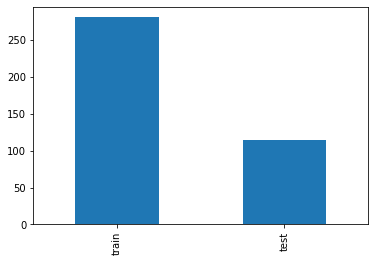

In [20]:
df['split'].value_counts().plot(kind='bar')

### Split Data

In [1]:
def build_sources_from_metadata(metadata, data_dir, mode='train', exclude_labels=None):
    
    if exclude_labels is None:
        exclude_labels = set()
    if isinstance(exclude_labels, (list, tuple)):
        exclude_labels = set(exclude_labels)

    df = metadata.copy()
    df = df[df['split'] == mode]
    df['filepath'] = df['img'].apply(lambda x: os.path.join(data_dir, x))
    include_mask = df['label'].apply(lambda x: x not in exclude_labels)
    df = df[include_mask]

    sources = list(zip(df['filepath'],zip(df["xmin"],df["xmax"],df["ymin"],df["ymax"]),df['label']))
    return sources


In [2]:
train_sources = build_sources_from_metadata(metadata, 'local/imgs')
test_sources = build_sources_from_metadata(metadata, 'local/imgs',mode='test')

NameError: name 'metadata' is not defined

In [34]:
print(type(train_sources))
print(train_sources[0:2])

<class 'list'>
[('local/imgs\\09-22-2020-14.53.24(1).jpg', (0.13741636644364386, 0.2799794132784354, 0.394873848618342, 0.42050460552663194), 1), ('local/imgs\\09-22-2020-14.53.24(10).jpg', (0.15344603381014305, 0.2919375812743823, 0.3913904007916873, 0.4151410192973775), 1)]


In [ ]:
def imshow_batch_of_three(batch, num_images = 1, show_label=True ):
    
    label_batch = batch[1].numpy()
    image_batch = batch[0].numpy()
    fig, axarr = plt.subplots(1, num_images, figsize=(15, 5), sharey=True)
    
    for i in range(num_images):
        img = image_batch[i, ...]
        axarr[i].imshow(img)
        if show_label:
            axarr[i].set(xlabel='label = {}'.format(label_batch[i]))

## TensorFlow DataSet

In [51]:
def preprocess_image(image):
    image = tf.image.resize(image, size=(224, 224))
    image = image / 255.0
    return image

def augment_image(image):
    return image

def make_dataset(sources, training=False, batch_size=1,
    num_epochs=1, num_parallel_calls=1, shuffle_buffer_size=None):
    
    """
    Returns an operation to iterate over the dataset specified in sources

    Args:
        sources (list): A list of (filepath, label_id) pairs.
        training (bool): whether to apply certain processing steps
            defined only in training mode (e.g. shuffle).
        batch_size (int): number of elements the resulting tensor
            should have.
        num_epochs (int): Number of epochs to repeat the dataset.
        num_parallel_calls (int): Number of parallel calls to use in
            map operations.
        shuffle_buffer_size (int): Number of elements from this dataset
            from which the new dataset will sample.

    Returns:
        A tf.data.Dataset object. It will return a tuple images of shape
        [N, H, W, CH] and labels shape [N, 1].
    """
    def load(row):
        filepath = row['image']
        img = tf.io.read_file(filepath)
        img = tf.io.decode_jpeg(img)
        return img, row['label']

    if shuffle_buffer_size is None:
        shuffle_buffer_size = batch_size*4

    images, Bounding_Box , labels = zip(*sources)
    
    ds = tf.data.Dataset.from_tensor_slices({
        'image': list(images),'bounding_box' : list(Bounding_Box), 'label': list(labels)}) 
 #line from the link. As with most code, if you remove an arbitrary line, expectin
    if training:
        ds = ds.shuffle(shuffle_buffer_size)
    
    ds = ds.map(load, num_parallel_calls=num_parallel_calls)
    ds = ds.map(lambda x,y: (preprocess_image(x), y))
    
    if training:
        ds = ds.map(lambda x,y: (augment_image(x), y))
        
    ds = ds.repeat(count=num_epochs)
    ds = ds.batch(batch_size=batch_size)
    ds = ds.prefetch(1)

    return ds

In [52]:
dataset = make_dataset(train_sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)

In [3]:
from local.data import load_data

ImportError: cannot import name 'load_data' from 'local.data' (unknown location)

In [4]:
%run local/data/lib/limyfile.py

Exception: File `'local/data/lib/limyfile.py'` not found.